# Giới thiệu

In [1]:
DATA_ROOT = "../../data/Traffic_flow-HCM"
PREPROCESS_ROOT = "../../data/preprocessed"

# Thư viện sử dụng

In [2]:
import numpy as np
import pandas as pd

import squarify

import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Xem từng file

## streets.csv

Thông tin đoạn đường ở TP. HCM. Có 5553 dòng, 6 cột

### Xem tổng quát

In [3]:
streets_df = pd.read_csv(f"{DATA_ROOT}/streets.csv")
streets_df.shape

(5553, 5)

In [4]:
streets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5553 entries, 0 to 5552
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           5553 non-null   int64  
 1   level         5553 non-null   int64  
 2   max_velocity  987 non-null    float64
 3   name          3948 non-null   object 
 4   type          5553 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 217.0+ KB


In [5]:
streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,NaN,NaN,unclassified
2,32575794,4,NaN,Chu Văn An,unclassified
3,32575820,4,NaN,Nguyễn Văn Bá,tertiary
4,32575823,4,NaN,Nguyễn Thị Nhỏ,tertiary


In [6]:
# Số lượng các giá trị bị thiếu
streets_df.isnull().sum()

_id                0
level              0
max_velocity    4566
name            1605
type               0
dtype: int64

In [7]:
#  Tỉ lệ các giá trị bị thiếu
streets_df.isnull().sum()*100/len(streets_df)

_id              0.000000
level            0.000000
max_velocity    82.225824
name            28.903296
type             0.000000
dtype: float64

In [8]:
streets_df.duplicated().sum()

np.int64(0)

### Xem thuộc tính của streets.csv

#### Id

In [9]:
print(len(streets_df["_id"].unique()))
streets_df["_id"].unique()

5553


array([ 31096786,  32575737,  32575794, ..., 656850719, 656851094,
       658328101], shape=(5553,))

#### Cấp công trình giao thông

In [10]:
level_arr = streets_df["level"]
level_counts = level_arr.value_counts()

In [11]:
level_counts

level
4    2930
3    1268
2     889
1     466
Name: count, dtype: int64

#### Tốc độ tối đa cho phép

In [12]:
velocity_arr = streets_df[streets_df["max_velocity"].notnull()]["max_velocity"]
velocity_arr.min(), \
velocity_arr.max()

(np.float64(10.0), np.float64(120.0))

In [13]:
velocity_counts = velocity_arr.value_counts()
velocity_counts

max_velocity
60.0     422
80.0     180
50.0     150
40.0     145
30.0      25
70.0      18
20.0      15
10.0       9
100.0      9
45.0       7
120.0      7
Name: count, dtype: int64

#### Tên đường

In [14]:
name_arr = streets_df[streets_df["name"].notnull()]["name"]
print(len(name_arr.unique())) # Số lượng tên khác nhau
print(len(name_arr)) # Số con đường được đặt tên
name_arr.unique()

1048
3948


array(['Quốc Lộ 1', 'Chu Văn An', 'Nguyễn Văn Bá', ..., 'X2', 'X1',
       'Đình Nghi Xuân'], shape=(1048,), dtype=object)

#### Loại đường

In [15]:
type_arr = streets_df[streets_df["name"].notnull()]["type"]
print(len(type_arr.unique()))
type_arr.unique()

11


array(['trunk', 'unclassified', 'tertiary', 'secondary', 'primary_link',
       'primary', 'trunk_link', 'tertiary_link', 'secondary_link',
       'motorway', 'motorway_link'], dtype=object)

In [16]:
type_counts = type_arr.value_counts()
type_counts

type
tertiary          1465
primary            800
secondary          525
unclassified       417
trunk              410
trunk_link         110
primary_link        97
motorway            40
secondary_link      31
motorway_link       27
tertiary_link       26
Name: count, dtype: int64

### Tiền xử lý

In [17]:
preprocess_streets_df = streets_df.copy()

#### Fill NaN velocity = -1

In [18]:
preprocess_streets_df["max_velocity"] = preprocess_streets_df["max_velocity"].fillna(-1)
preprocess_streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,-1.0,NaN,unclassified
2,32575794,4,-1.0,Chu Văn An,unclassified
3,32575820,4,-1.0,Nguyễn Văn Bá,tertiary
4,32575823,4,-1.0,Nguyễn Thị Nhỏ,tertiary


#### Fill NaN name = (không tên)

In [19]:
preprocess_streets_df["name"] = preprocess_streets_df["name"].fillna("(không tên)")
preprocess_streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,1,80.0,Quốc Lộ 1,trunk
1,32575737,4,-1.0,(không tên),unclassified
2,32575794,4,-1.0,Chu Văn An,unclassified
3,32575820,4,-1.0,Nguyễn Văn Bá,tertiary
4,32575823,4,-1.0,Nguyễn Thị Nhỏ,tertiary


#### Ordinal encoding level

In [20]:
preprocess_streets_df["level"] = preprocess_streets_df["level"] - 1
preprocess_streets_df.head()

,_id,level,max_velocity,name,type
0,31096786,0,80.0,Quốc Lộ 1,trunk
1,32575737,3,-1.0,(không tên),unclassified
2,32575794,3,-1.0,Chu Văn An,unclassified
3,32575820,3,-1.0,Nguyễn Văn Bá,tertiary
4,32575823,3,-1.0,Nguyễn Thị Nhỏ,tertiary


### Lưu csv

In [21]:
preprocess_streets_df.to_csv(f"{PREPROCESS_ROOT}/streets.csv", index=False)

## nodes.csv

File nodes.csv gồm 577967 dòng, 3 cột gồm: id của node, vĩ dộ, kinh độ tại vị trí đặt sensor

In [22]:
nodes_df = pd.read_csv(f"{DATA_ROOT}/nodes.csv")
nodes_df.shape

(577967, 3)

In [23]:
nodes_df.head()

,_id,long,lat
0,366367223,106.629056,10.804243
1,366367233,106.709701,10.771110
2,366367242,106.737189,10.709337
3,366367274,106.760081,10.854489
4,366367285,106.721163,10.804994


In [24]:
nodes_df.isnull().sum()

_id     0
long    0
lat     0
dtype: int64

In [25]:
nodes_df.duplicated().sum()

np.int64(0)

In [26]:
nodes_df.dtypes

_id       int64
long    float64
lat     float64
dtype: object

In [27]:
long_arr = nodes_df["long"]
lat_arr = nodes_df["lat"]

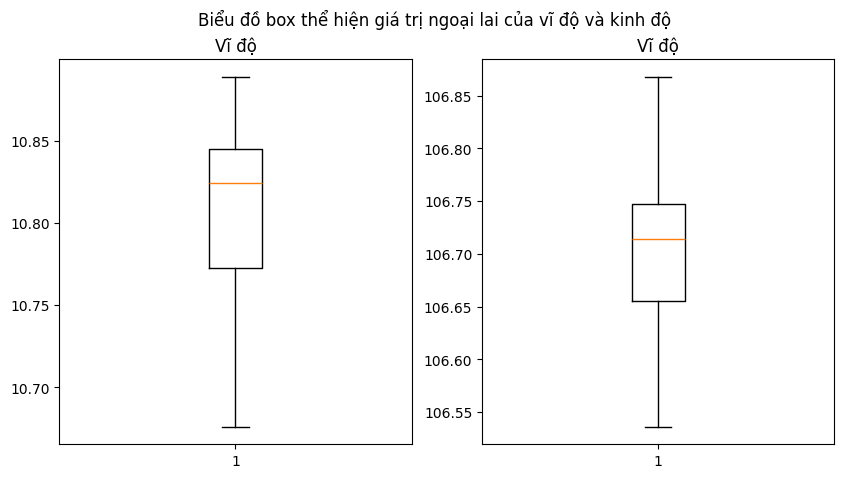

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Biểu đồ box thể hiện giá trị ngoại lai của vĩ độ và kinh độ")

axes[0].set_title("Vĩ độ")
axes[0].boxplot(lat_arr)

axes[1].set_title("Vĩ độ")
axes[1].boxplot(long_arr)
plt.show()

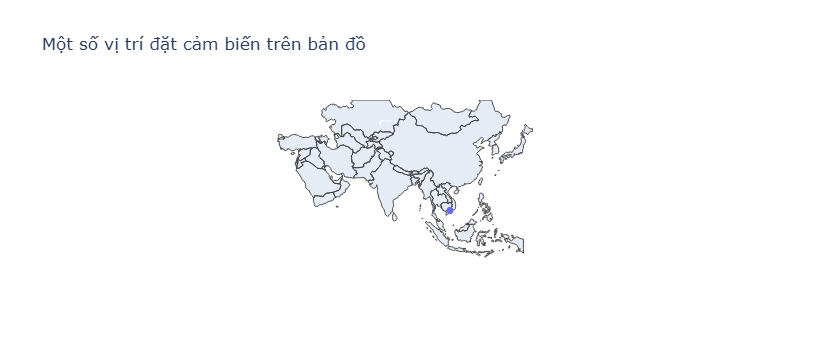

In [29]:
fig = go.Figure(data=go.Scattergeo(
        lon = long_arr[:10],
        lat = lat_arr[:10],
        ))
fig.update_layout(
        title = 'Một số vị trí đặt cảm biến trên bản đồ',
        geo_scope='asia',
    )
fig.show()

In [30]:
nodes_df["long"].min(), \
nodes_df["long"].max()

(np.float64(106.5360046), np.float64(106.8679941))

In [31]:
nodes_df["lat"].min(), \
nodes_df["lat"].max()

(np.float64(10.6760012), np.float64(10.8889982))

In [32]:
# Lưu nodes.csv nguyên vẹn
nodes_df.to_csv(f"{PREPROCESS_ROOT}/nodes.csv", index=False)

## segments.csv

### Xem tổng quát

In [33]:
segments_df = pd.read_csv(f"{DATA_ROOT}/segments.csv")
segments_df.shape

(84633, 11)

In [34]:
segments_df.head()

,_id,created_at,updated_at,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type
0,0,2020-10-18T13:26:17.365Z,2020-10-18T13:26:17.365Z,373543511,5468660805,114,31096786,80.0,1,Quốc Lộ 1,trunk
1,1,2020-10-18T13:26:17.400Z,2020-10-18T13:26:17.400Z,5468660805,5738158916,9,31096786,80.0,1,Quốc Lộ 1,trunk
2,2,2020-10-18T13:26:17.435Z,2020-10-18T13:26:17.435Z,5738158916,5738158918,23,31096786,80.0,1,Quốc Lộ 1,trunk
3,3,2020-10-18T13:26:17.444Z,2020-10-18T13:26:17.444Z,5738158918,5738158912,66,31096786,80.0,1,Quốc Lộ 1,trunk
4,4,2020-10-18T13:26:17.452Z,2020-10-18T13:26:17.452Z,5738158912,5758104203,127,31096786,80.0,1,Quốc Lộ 1,trunk


In [35]:
segments_df.describe()

,_id,s_node_id,e_node_id,length,street_id,max_velocity,street_level
count,84633.000000,8.463300e+04,8.463300e+04,84633.000000,8.463300e+04,9871.000000,84633.000000
mean,42316.000000,3.674041e+09,3.672725e+09,41.818050,2.866904e+08,54.503596,3.500006
std,24431.587003,2.039756e+09,2.040056e+09,52.692336,2.085526e+08,16.553367,0.841222
min,0.000000,3.663672e+08,3.663672e+08,0.000000,3.109679e+07,10.000000,1.000000
25%,21158.000000,2.078951e+09,2.078951e+09,13.000000,3.511357e+07,40.000000,3.000000
50%,42316.000000,4.068031e+09,4.068031e+09,27.000000,2.517313e+08,60.000000,4.000000
75%,63474.000000,5.748273e+09,5.748270e+09,52.000000,4.693276e+08,60.000000,4.000000
max,84632.000000,6.175932e+09,6.175932e+09,1622.000000,6.583281e+08,120.000000,4.000000


In [36]:
segments_df.duplicated().sum()

np.int64(0)

In [37]:
# Số lượng các giá trị bị thiếu trong segments.csv
segments_df.isnull().sum()

_id                 0
created_at          0
updated_at          0
s_node_id           0
e_node_id           0
length              0
street_id           0
max_velocity    74762
street_level        0
street_name       152
street_type         0
dtype: int64

In [38]:
# Tỉ lệ các giá trị bị thiếu trong segments.csv
segments_df.isnull().sum()*100/len(segments_df)

_id              0.000000
created_at       0.000000
updated_at       0.000000
s_node_id        0.000000
e_node_id        0.000000
length           0.000000
street_id        0.000000
max_velocity    88.336701
street_level     0.000000
street_name      0.179599
street_type      0.000000
dtype: float64

### Chuyển kiểu chuỗi về dạng thời gian

In [39]:
segments_df["created_at"] = pd.to_datetime(segments_df["created_at"])
segments_df["updated_at"] = pd.to_datetime(segments_df["updated_at"])
segments_df.dtypes

_id                           int64
created_at      datetime64[ns, UTC]
updated_at      datetime64[ns, UTC]
s_node_id                     int64
e_node_id                     int64
length                        int64
street_id                     int64
max_velocity                float64
street_level                  int64
street_name                  object
street_type                  object
dtype: object

### Xem từng thuộc tính

#### created_at

In [40]:
segments_df["created_at"].min(), \
segments_df["created_at"].max()

(Timestamp('2020-10-18 13:26:17.365000+0000', tz='UTC'),
 Timestamp('2020-10-18 13:30:29.803000+0000', tz='UTC'))

#### updated_at

In [41]:
segments_df["updated_at"].min(), \
segments_df["updated_at"].max()

(Timestamp('2020-10-18 13:26:17.365000+0000', tz='UTC'),
 Timestamp('2021-04-04 17:00:46.926000+0000', tz='UTC'))

#### length

In [42]:
segments_df["length"].min(), \
segments_df["length"].max()

(np.int64(0), np.int64(1622))

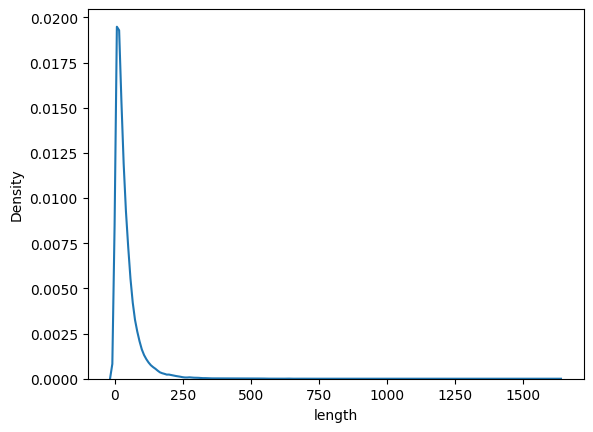

In [43]:
sns.kdeplot(segments_df["length"])
plt.show()

In [44]:
segments_df["length"].describe()

count    84633.000000
mean        41.818050
std         52.692336
min          0.000000
25%         13.000000
50%         27.000000
75%         52.000000
max       1622.000000
Name: length, dtype: float64

#### street_id

In [45]:
len(segments_df["street_id"].unique())

5539

In [46]:
segments_df.head()

,_id,created_at,updated_at,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type
0,0,2020-10-18 13:26:17.365000+00:00,2020-10-18 13:26:17.365000+00:00,373543511,5468660805,114,31096786,80.0,1,Quốc Lộ 1,trunk
1,1,2020-10-18 13:26:17.400000+00:00,2020-10-18 13:26:17.400000+00:00,5468660805,5738158916,9,31096786,80.0,1,Quốc Lộ 1,trunk
2,2,2020-10-18 13:26:17.435000+00:00,2020-10-18 13:26:17.435000+00:00,5738158916,5738158918,23,31096786,80.0,1,Quốc Lộ 1,trunk
3,3,2020-10-18 13:26:17.444000+00:00,2020-10-18 13:26:17.444000+00:00,5738158918,5738158912,66,31096786,80.0,1,Quốc Lộ 1,trunk
4,4,2020-10-18 13:26:17.452000+00:00,2020-10-18 13:26:17.452000+00:00,5738158912,5758104203,127,31096786,80.0,1,Quốc Lộ 1,trunk


#### max_velocity

In [47]:
max_velocity_arr = segments_df["max_velocity"]

In [48]:
max_velocity_arr.min(), \
max_velocity_arr.max()

(np.float64(10.0), np.float64(120.0))

In [49]:
max_velocity_counts = max_velocity_arr.value_counts()
max_velocity_counts

max_velocity
60.0     3314
40.0     1915
80.0     1601
50.0     1595
30.0      710
20.0      259
70.0      222
45.0      133
10.0       69
120.0      37
100.0      16
Name: count, dtype: int64

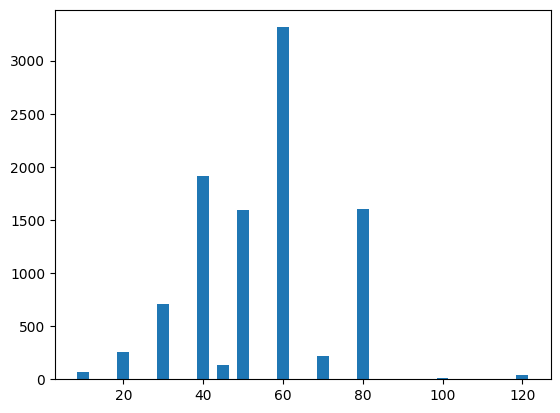

In [50]:
plt.bar(max_velocity_counts.index, max_velocity_counts, 3)
plt.show()

 #### street_level

In [51]:
segments_df["street_level"].value_counts()

street_level
4    58097
3    14342
2     8608
1     3586
Name: count, dtype: int64

#### street_name

In [52]:
print(len(segments_df["street_name"].unique()))
segments_df["street_name"].unique()

1389


array(['Quốc Lộ 1', 'Thương Mại', 'Xã Trung Chánh', ...,
       'Đường Nguyễn Duy Trinh',
       'Đường Song Hành Xa lộ Hà Nội - Nhánh Thủ Đức', 'Đình Nghi Xuân'],
      shape=(1389,), dtype=object)

In [53]:
#### street_type

In [54]:
print(len(segments_df["street_type"].unique()))
segments_df["street_type"].unique()

53


array(['trunk', 'marketplace', 'unclassified', 'tertiary', 'secondary',
       'primary_link', 'primary', 'bus_station', 'bank', 'residential',
       'fuel', 'department_store', 'trunk_link', 'theme_park',
       'tertiary_link', 'secondary_link', 'bridge', 'apartments',
       'hostel', 'fire_station', 'convenience', 'shelter',
       'training_area', 'pedestrian', 'dry_cleaning', 'motorway_link',
       'chalet', 'motorway', 'pitch', 'industrial', 'dormitory',
       'university', 'bus_stop', 'service', 'car', 'house', 'company',
       'school', 'college', 'construction', 'restaurant', 'hospital',
       'yes', 'government', 'clothes', 'dentist', 'atm', 'fast_food',
       'swimming_pool', 'police', 'church', 'cinema', 'community_centre'],
      dtype=object)

### Tiền xử lý

In [55]:
preprocess_segments_df = segments_df.copy()

#### Kiểm tra thuộc tính tĩnh/động

In [56]:
for col in segments_df.columns:
    if col in ["street_id", "_id"]:
        continue

    uniques_per_segment = segments_df.groupby("street_id")[col].nunique()
    max_unique_values = uniques_per_segment.max()

    print(f"\nKiểm tra cột: '{col}'")
    print(f"  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: {max_unique_values}")


Kiểm tra cột: 'created_at'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 324

Kiểm tra cột: 'updated_at'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 324

Kiểm tra cột: 's_node_id'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 163

Kiểm tra cột: 'e_node_id'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 163

Kiểm tra cột: 'length'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 84

Kiểm tra cột: 'max_velocity'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_level'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_name'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 6

Kiểm tra cột: 'street_type'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 9


#### Fill street_name NULL = (không tên)

In [57]:
preprocess_segments_df["street_name"] = preprocess_segments_df["street_name"].fillna("(không tên)")
preprocess_segments_df.isnull().sum()

_id                 0
created_at          0
updated_at          0
s_node_id           0
e_node_id           0
length              0
street_id           0
max_velocity    74762
street_level        0
street_name         0
street_type         0
dtype: int64

#### Fill max velocity NULL = -1

#### One-hot encoding cho street type

In [58]:
preprocess_segments_df["max_velocity"] = preprocess_segments_df["max_velocity"].fillna(-1)
preprocess_segments_df.isnull().sum()

_id             0
created_at      0
updated_at      0
s_node_id       0
e_node_id       0
length          0
street_id       0
max_velocity    0
street_level    0
street_name     0
street_type     0
dtype: int64

#### Đổi tên id

In [59]:
preprocess_segments_df = preprocess_segments_df.rename(columns={"_id": "segment_id"})
preprocess_segments_df.head()

,segment_id,created_at,updated_at,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type
0,0,2020-10-18 13:26:17.365000+00:00,2020-10-18 13:26:17.365000+00:00,373543511,5468660805,114,31096786,80.0,1,Quốc Lộ 1,trunk
1,1,2020-10-18 13:26:17.400000+00:00,2020-10-18 13:26:17.400000+00:00,5468660805,5738158916,9,31096786,80.0,1,Quốc Lộ 1,trunk
2,2,2020-10-18 13:26:17.435000+00:00,2020-10-18 13:26:17.435000+00:00,5738158916,5738158918,23,31096786,80.0,1,Quốc Lộ 1,trunk
3,3,2020-10-18 13:26:17.444000+00:00,2020-10-18 13:26:17.444000+00:00,5738158918,5738158912,66,31096786,80.0,1,Quốc Lộ 1,trunk
4,4,2020-10-18 13:26:17.452000+00:00,2020-10-18 13:26:17.452000+00:00,5738158912,5758104203,127,31096786,80.0,1,Quốc Lộ 1,trunk


#### Ordinal encoding street_level

In [60]:
preprocess_segments_df["street_level"] = preprocess_segments_df["street_level"] - 1

### Lưu segments.csv

In [61]:
preprocess_segments_df.to_csv(f"{PREPROCESS_ROOT}/segments.csv", index=False)

## segment_status.csv

### Xem tổng quát

In [62]:
segment_status_df = pd.read_csv(f"{DATA_ROOT}/segment_status.csv")

# Chuyển về kiểu thời gian
segment_status_df["updated_at"] = pd.to_datetime(segment_status_df["updated_at"])
segment_status_df.shape

(90938, 4)

In [63]:
segment_status_df.head()

,_id,updated_at,segment_id,velocity
0,0,2020-07-03 14:55:31.869000+00:00,24845,20
1,1,2020-07-03 15:02:56.048000+00:00,33923,10
2,2,2020-07-04 08:15:52.696000+00:00,33824,5
3,3,2020-07-04 08:15:59.903000+00:00,33824,5
4,4,2020-07-04 08:16:08.201000+00:00,33824,5


In [64]:
segment_status_df.isnull().sum()

_id           0
updated_at    0
segment_id    0
velocity      0
dtype: int64

In [65]:
segment_status_df.duplicated().sum()

np.int64(0)

In [66]:
segment_status_df["updated_at"].min(), \
segment_status_df["updated_at"].max()

(Timestamp('2020-07-03 14:55:31.869000+0000', tz='UTC'),
 Timestamp('2021-04-22 06:53:27.300000+0000', tz='UTC'))

In [67]:
segment_status_df["velocity"].min(), \
segment_status_df["velocity"].max()

(np.int64(0), np.int64(200))

### Xem từng thuộc tính

#### updated_at

In [68]:
segment_status_df["updated_at"].min(), \
segment_status_df["updated_at"].max()

(Timestamp('2020-07-03 14:55:31.869000+0000', tz='UTC'),
 Timestamp('2021-04-22 06:53:27.300000+0000', tz='UTC'))

#### segment_id

In [69]:
print(len(segment_status_df["segment_id"].unique()))
segment_status_df["segment_id"].unique()

10027


array([24845, 33923, 33824, ..., 52243, 52246, 52247], shape=(10027,))

#### velocity

In [70]:
segment_status_df["velocity"].describe()

count    90938.000000
mean        20.754844
std         19.567112
min          0.000000
25%          2.000000
50%         17.000000
75%         34.000000
max        200.000000
Name: velocity, dtype: float64

### Kiểm tra tính tĩnh/động của velocity

In [71]:
velocity_uniques = segment_status_df.groupby("segment_id")["velocity"].nunique()
max_unique_values = velocity_uniques.max()
print(max_unique_values)

42


### Lưu file segment_status.csv không xử lý gì thêm

In [72]:
segment_status_df.to_csv(f"{PREPROCESS_ROOT}/segment_status.csv", index=False)

## train.csv

### Xem tổng quát

In [73]:
train_df = pd.read_csv(f"{DATA_ROOT}/train.csv")
train_df["date"] = pd.to_datetime(train_df["date"])
train_df.shape

(33441, 18)

In [74]:
train_df.head()

,_id,segment_id,date,weekday,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type,long_snode,lat_snode,long_enode,lat_enode
0,0,26,2021-04-16,4,period_0_30,A,366428456,366416066,116,32575820,NaN,4,Nguyễn Văn Bá,tertiary,106.768732,10.841506,106.769254,10.842422
1,1,33,2020-08-02,6,period_23_30,C,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808
2,2,33,2020-08-03,0,period_0_00,D,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808
3,3,67,2021-03-09,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771
4,4,67,2021-03-23,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           33441 non-null  int64         
 1   segment_id    33441 non-null  int64         
 2   date          33441 non-null  datetime64[ns]
 3   weekday       33441 non-null  int64         
 4   period        33441 non-null  object        
 5   LOS           33441 non-null  object        
 6   s_node_id     33441 non-null  int64         
 7   e_node_id     33441 non-null  int64         
 8   length        33441 non-null  int64         
 9   street_id     33441 non-null  int64         
 10  max_velocity  4946 non-null   float64       
 11  street_level  33441 non-null  int64         
 12  street_name   33440 non-null  object        
 13  street_type   33441 non-null  object        
 14  long_snode    33441 non-null  float64       
 15  lat_snode     33441 non-null  float6

In [76]:
train_df.describe()

,_id,segment_id,date,weekday,s_node_id,e_node_id,length,street_id,max_velocity,street_level,long_snode,lat_snode,long_enode,lat_enode
count,33441.000000,33441.000000,33441,33441.000000,3.344100e+04,3.344100e+04,33441.000000,3.344100e+04,4946.000000,33441.000000,33441.000000,33441.000000,33441.000000,33441.000000
mean,16720.000000,41014.936575,2020-11-23 07:51:25.852695552,2.915254,3.528928e+09,3.582345e+09,48.709010,2.715539e+08,59.299434,3.029993,106.670354,10.804326,106.670334,10.804352
min,0.000000,26.000000,2020-07-03 00:00:00,0.000000,3.663674e+08,3.663678e+08,0.000000,3.257582e+07,10.000000,1.000000,106.537476,10.676452,106.537776,10.676467
25%,8360.000000,21967.000000,2020-11-18 00:00:00,1.000000,2.079964e+09,2.079965e+09,17.000000,5.588046e+07,50.000000,2.000000,106.649521,10.772135,106.649478,10.772131
50%,16720.000000,41654.000000,2020-12-07 00:00:00,3.000000,3.771416e+09,4.066314e+09,34.000000,2.420036e+08,60.000000,3.000000,106.664687,10.797884,106.664704,10.797776
75%,25080.000000,58456.000000,2020-12-26 00:00:00,5.000000,5.738236e+09,5.748445e+09,63.000000,4.082464e+08,60.000000,4.000000,106.685096,10.837117,106.685212,10.837388
max,33440.000000,84535.000000,2021-04-22 00:00:00,6.000000,6.175932e+09,6.175932e+09,1011.000000,6.565625e+08,120.000000,4.000000,106.867740,10.888965,106.867654,10.888993
std,9653.729512,22489.675329,NaN,2.329021,2.008085e+09,2.014716e+09,52.251062,1.908930e+08,14.172472,1.022137,0.041887,0.040358,0.041868,0.040377


In [77]:
train_df.isnull().sum()

_id                 0
segment_id          0
date                0
weekday             0
period              0
LOS                 0
s_node_id           0
e_node_id           0
length              0
street_id           0
max_velocity    28495
street_level        0
street_name         1
street_type         0
long_snode          0
lat_snode           0
long_enode          0
lat_enode           0
dtype: int64

In [78]:
train_df.duplicated().sum()

np.int64(0)

### Kiểm tra từng thuộc tính

#### length

In [79]:
train_df["length"].describe()

count    33441.000000
mean        48.709010
std         52.251062
min          0.000000
25%         17.000000
50%         34.000000
75%         63.000000
max       1011.000000
Name: length, dtype: float64

#### date

In [80]:
train_df["date"].describe()

count                            33441
mean     2020-11-23 07:51:25.852695552
min                2020-07-03 00:00:00
25%                2020-11-18 00:00:00
50%                2020-12-07 00:00:00
75%                2020-12-26 00:00:00
max                2021-04-22 00:00:00
Name: date, dtype: object

#### max_velocity

In [81]:
train_df["max_velocity"].describe()

count    4946.000000
mean       59.299434
std        14.172472
min        10.000000
25%        50.000000
50%        60.000000
75%        60.000000
max       120.000000
Name: max_velocity, dtype: float64

#### street_name

In [82]:
train_df["street_name"].describe()

count          33440
unique           695
top       Lê Đức Thọ
freq            1389
Name: street_name, dtype: object

#### street_type

In [83]:
train_df["street_type"].describe()

count        33441
unique          26
top       tertiary
freq         13857
Name: street_type, dtype: object

### Tiền xử lý

In [84]:
preprocess_train_df = train_df.copy()

#### Kiểm tra thuộc tính tĩnh/động

In [85]:
for col in train_df.columns:
    if col in ["segment_id", "_id"]:
        continue

    uniques_per_segment = train_df.groupby("segment_id")[col].nunique()
    max_unique_values = uniques_per_segment.max()

    print(f"\nKiểm tra cột: '{col}'")
    print(f"  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: {max_unique_values}")


Kiểm tra cột: 'date'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 28

Kiểm tra cột: 'weekday'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 7

Kiểm tra cột: 'period'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 26

Kiểm tra cột: 'LOS'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 6

Kiểm tra cột: 's_node_id'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'e_node_id'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'length'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_id'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'max_velocity'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_level'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_name'
  Số lượng giá trị duy nhất TỐI ĐA cho bất kỳ segment nào: 1

Kiểm tra cột: 'street_type'
  Số lượng g

#### Xem các giá trị của thuộc tính

In [86]:
# weekday
train_df["weekday"].unique()

array([4, 6, 0, 1, 2, 5, 3])

In [87]:
# Level of service
train_df["LOS"].unique()

array(['A', 'C', 'D', 'B', 'E', 'F'], dtype=object)

In [88]:
# Period
train_df["period"].unique()

array(['period_0_30', 'period_23_30', 'period_0_00', 'period_9_30',
       'period_4_30', 'period_7_30', 'period_14_00', 'period_3_00',
       'period_4_00', 'period_14_30', 'period_5_00', 'period_6_30',
       'period_7_00', 'period_5_30', 'period_6_00', 'period_15_00',
       'period_3_30', 'period_8_00', 'period_13_30', 'period_2_30',
       'period_10_30', 'period_11_00', 'period_1_00', 'period_11_30',
       'period_12_00', 'period_12_30', 'period_8_30', 'period_9_00',
       'period_10_00', 'period_1_30', 'period_15_30', 'period_2_00',
       'period_16_00', 'period_23_00', 'period_13_00', 'period_22_30',
       'period_21_30', 'period_22_00', 'period_17_30', 'period_18_00',
       'period_16_30', 'period_17_00', 'period_20_00', 'period_19_30',
       'period_18_30', 'period_19_00'], dtype=object)

#### Trích xuất period

In [89]:
period_parts  = preprocess_train_df['period'].str.split('_', expand=True)
preprocess_train_df['hour'] = period_parts [1].astype(int)
preprocess_train_df['minute'] = period_parts [2].astype(int)
preprocess_train_df.head()

,_id,segment_id,date,weekday,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type,long_snode,lat_snode,long_enode,lat_enode,hour,minute
0,0,26,2021-04-16,4,period_0_30,A,366428456,366416066,116,32575820,NaN,4,Nguyễn Văn Bá,tertiary,106.768732,10.841506,106.769254,10.842422,0,30
1,1,33,2020-08-02,6,period_23_30,C,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808,23,30
2,2,33,2020-08-03,0,period_0_00,D,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808,0,0
3,3,67,2021-03-09,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771,9,30
4,4,67,2021-03-23,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771,9,30


#### Ordinal encoding LOS

In [90]:
los_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
preprocess_train_df['LOS_encoded'] = preprocess_train_df['LOS'].map(los_mapping)
preprocess_train_df.head()

,_id,segment_id,date,weekday,period,LOS,s_node_id,e_node_id,length,street_id,...,street_level,street_name,street_type,long_snode,lat_snode,long_enode,lat_enode,hour,minute,LOS_encoded
0,0,26,2021-04-16,4,period_0_30,A,366428456,366416066,116,32575820,...,4,Nguyễn Văn Bá,tertiary,106.768732,10.841506,106.769254,10.842422,0,30,0
1,1,33,2020-08-02,6,period_23_30,C,366469460,3792257828,26,32575862,...,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808,23,30,2
2,2,33,2020-08-03,0,period_0_00,D,366469460,3792257828,26,32575862,...,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808,0,0,3
3,3,67,2021-03-09,1,period_9_30,B,366403668,5755066033,7,32575862,...,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771,9,30,1
4,4,67,2021-03-23,1,period_9_30,B,366403668,5755066033,7,32575862,...,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771,9,30,1


#### Ordinal encoding street_level

In [91]:
preprocess_train_df["street_level"] = preprocess_train_df["street_level"] - 1

#### One-hot encoding weekday

In [92]:
preprocess_train_df = pd.get_dummies(preprocess_train_df, columns=["weekday"])
preprocess_train_df.head()

,_id,segment_id,date,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,...,hour,minute,LOS_encoded,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,26,2021-04-16,period_0_30,A,366428456,366416066,116,32575820,NaN,...,0,30,0,False,False,False,False,True,False,False
1,1,33,2020-08-02,period_23_30,C,366469460,3792257828,26,32575862,NaN,...,23,30,2,False,False,False,False,False,False,True
2,2,33,2020-08-03,period_0_00,D,366469460,3792257828,26,32575862,NaN,...,0,0,3,True,False,False,False,False,False,False
3,3,67,2021-03-09,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,9,30,1,False,True,False,False,False,False,False
4,4,67,2021-03-23,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,9,30,1,False,True,False,False,False,False,False


#### One-hot encoding street_type

In [93]:
preprocess_train_df = pd.get_dummies(preprocess_train_df, columns=["street_type"])
preprocess_train_df.head()

,_id,segment_id,date,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,...,street_type_residential,street_type_school,street_type_secondary,street_type_secondary_link,street_type_tertiary,street_type_tertiary_link,street_type_trunk,street_type_trunk_link,street_type_unclassified,street_type_university
0,0,26,2021-04-16,period_0_30,A,366428456,366416066,116,32575820,NaN,...,False,False,False,False,True,False,False,False,False,False
1,1,33,2020-08-02,period_23_30,C,366469460,3792257828,26,32575862,NaN,...,False,False,True,False,False,False,False,False,False,False
2,2,33,2020-08-03,period_0_00,D,366469460,3792257828,26,32575862,NaN,...,False,False,True,False,False,False,False,False,False,False
3,3,67,2021-03-09,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,False,False,True,False,False,False,False,False,False,False
4,4,67,2021-03-23,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,False,False,True,False,False,False,False,False,False,False


### Lưu train.csv

In [94]:
preprocess_train_df.to_csv(f"{PREPROCESS_ROOT}/train.csv", index=False)

# Trực quan giờ cao điểm

In [95]:
preprocess_train_df["time_index"] = preprocess_train_df["hour"] * 60 + preprocess_train_df["minute"]
preprocess_train_df["time_label"] = preprocess_train_df['hour'].astype(str).str.zfill(2) + ':' + preprocess_train_df['minute'].astype(str).str.zfill(2)
preprocess_train_df.head()

,_id,segment_id,date,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,...,street_type_secondary,street_type_secondary_link,street_type_tertiary,street_type_tertiary_link,street_type_trunk,street_type_trunk_link,street_type_unclassified,street_type_university,time_index,time_label
0,0,26,2021-04-16,period_0_30,A,366428456,366416066,116,32575820,NaN,...,False,False,True,False,False,False,False,False,30,00:30
1,1,33,2020-08-02,period_23_30,C,366469460,3792257828,26,32575862,NaN,...,True,False,False,False,False,False,False,False,1410,23:30
2,2,33,2020-08-03,period_0_00,D,366469460,3792257828,26,32575862,NaN,...,True,False,False,False,False,False,False,False,0,00:00
3,3,67,2021-03-09,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,True,False,False,False,False,False,False,False,570,09:30
4,4,67,2021-03-23,period_9_30,B,366403668,5755066033,7,32575862,NaN,...,True,False,False,False,False,False,False,False,570,09:30


In [96]:
traffic_stats = preprocess_train_df.groupby(['time_index', "time_label"])['LOS_encoded'].mean().reset_index()
traffic_stats.head()

,time_index,time_label,LOS_encoded
0,0,00:00,2.852612
1,30,00:30,2.489573
2,60,01:00,2.749271
3,90,01:30,2.716518
4,120,02:00,2.332436


In [97]:
time_labels = traffic_stats["time_label"]
time_labels.head()

0    00:00
1    00:30
2    01:00
3    01:30
4    02:00
Name: time_label, dtype: object

In [98]:
los_mean = traffic_stats["LOS_encoded"].mean()
peaks = traffic_stats[traffic_stats["LOS_encoded"] > los_mean]
peak_indices = peaks.index
print(peak_indices)

Index([0, 1, 2, 3, 4, 21, 22, 23, 24, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45], dtype='int64')


In [99]:
start_peaks = []
end_peaks = []

segment_start = peak_indices[0]

for i in range(1, len(peak_indices)):
    if peak_indices[i] != peak_indices[i - 1] + 1:
        segment_end = peak_indices[i - 1]

        if segment_end - segment_start + 1 >= 2:
            start_peaks.append(segment_start)
            end_peaks.append(segment_end)

        segment_start = peak_indices[i]

# handle last segment
segment_end = peak_indices[-1]
if segment_end - segment_start + 1 >= 2:
    start_peaks.append(segment_start)
    end_peaks.append(segment_end)

print(start_peaks)
print(end_peaks)

[np.int64(0), np.int64(21), np.int64(33), np.int64(39)]
[np.int64(4), np.int64(24), np.int64(37), np.int64(41)]


In [100]:
start_labels = time_labels[start_peaks].values
end_labels = time_labels[end_peaks].values
start_labels, end_labels

(array(['00:00', '10:30', '16:30', '19:30'], dtype=object),
 array(['02:00', '12:00', '18:30', '21:30'], dtype=object))

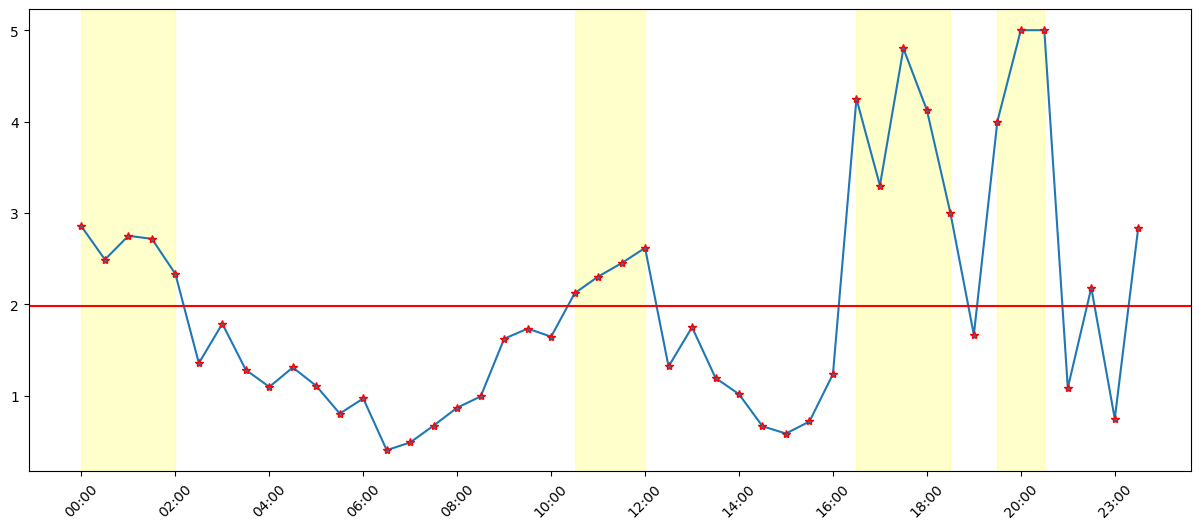

In [101]:
plt.figure(figsize=(15, 6))
plt.plot(traffic_stats["time_label"], traffic_stats["LOS_encoded"], marker="*", mec="r")
plt.axhline(los_mean, c="r")
for idx in range(len(start_labels)):
    plt.axvspan(
        start_labels[idx], 
        end_labels[idx], 
        alpha=0.2, color="yellow")
plt.xticks(np.arange(0, 48, 4), rotation=45)
plt.show()